# Probably Interesting Data
 - Dalton Hahn (2762306) and Ron Andrews (1083734)
## Audio features of songs ranging from 1922 to 2011

### Build a heuristic to model the data using mixture models of probability distributions programmatically
https://www.kaggle.com/uciml/msd-audio-features



## Madness Method
We will first investigate the data available in the kaggle dataset for Timbre from various songs over time to identify the trends in the data - looking for interesting features in the data.
Once we have determined the values of focus, we will normalize the data using a Guassian Normal Distribution Function.
With the normalized model data, we will plot the values, looking for interesting trends in the data. We will remove data that is uninteresting (few characteristics) or which go out of bounds from the more 'normal' dataset.
At the end, with our final collection of data parameters, we will plot a mean function against the data to see where the moderate pattern lies.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import math
from statistics import mean, stdev

## Read in the data

In [2]:
df = pd.read_csv("../data/external/audio-features-of-songs-ranging-from-1922-to-2011.zip", compression="zip")

In [3]:
df.head(1)

,label,TimbreAvg1,TimbreAvg2,TimbreAvg3,TimbreAvg4,TimbreAvg5,TimbreAvg6,TimbreAvg7,TimbreAvg8,TimbreAvg9,...,TimbreCovariance69,TimbreCovariance70,TimbreCovariance71,TimbreCovariance72,TimbreCovariance73,TimbreCovariance74,TimbreCovariance75,TimbreCovariance76,TimbreCovariance77,TimbreCovariance78
0,2001,49.94357,21.47114,73.0775,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.0162,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327


## Feature Engineering

In [4]:
df[df.columns[0]].unique()

array([2001, 2007, 2008, 2002, 2004, 2003, 1999, 1992, 1997, 1987, 2000,
       2005, 1996, 1998, 2009, 2006, 1993, 1991, 1933, 1930, 1935, 1995,
       1941, 1990, 1943, 1994, 1974, 1976, 1975, 1970, 1971, 1981, 1989,
       1969, 1972, 1973, 1983, 2010, 1985, 1988, 1979, 1980, 1986, 1958,
       1978, 1968, 1962, 1967, 1982, 1984, 1961, 1966, 1964, 1960, 1965,
       1963, 1977, 1942, 1945, 1955, 1926, 1927, 1957, 1959, 1956, 1954,
       1928, 1948, 1922, 1952, 1953, 1944, 1946, 1949, 1950, 1939, 1932,
       1938, 1937, 1936, 1940, 1951, 1929, 1934, 1947, 1931, 1925, 1924,
       2011])

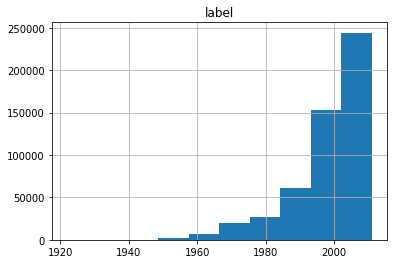

In [5]:
hist = df.hist(column = df.columns[0])

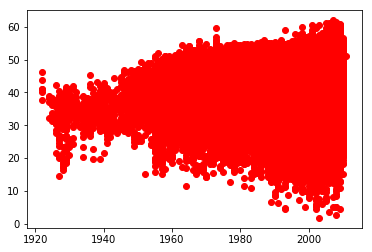

In [6]:
plt.plot(df['label'], df['TimbreAvg1'], 'ro')
plt.show()

Based on observation from distribution of songs over years, we plan to trim dataset to focus on solely songs produced in the year 2000 or later.  This still provides us a large amount of data to work with.

In [7]:
df2 = df[['label', 'TimbreAvg1']].copy()

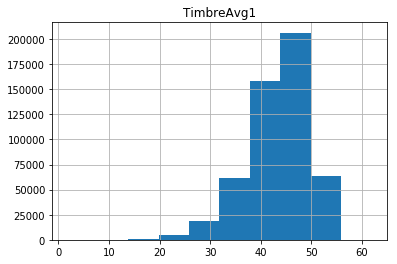

In [8]:
hist2 = df2.hist(column = df2.columns[1])

## Work the data into a Mixed Guassian Model

#### Guassian Transformation
The following function, gauss_transform, goes through the dataset and normalizes all of the values using a Gaussian distribution function: 
$\Large \mathcal{N}(x|\mu,\sigma^2) = \frac{1}{\sigma \sqrt{2 \pi}}    e^{-\frac{(x - \mu)^2}{2 (\mu^2)}}$

In [40]:
def gauss_transform(col):
    result_arr = []
    
    mu = mean(col)
    sig = stdev(col)
    frac_part = 1/(sig*math.sqrt(2*math.pi))
    for val in col:
        exponent_part = ((val - mu)**2) / (2*(mu**2)) * -1
        result_arr.append(frac_part * math.exp(exponent_part))
        
    return result_arr
        

### Maximum Likelihood for Gaussian Distribution
As per Bishop, the simple form for calculating likelihood is:
$\Large \mu = \frac{1}{N}\Sigma_{n=1}^{N}x_n$ a.k.a. $\Large \pi_k$

In [41]:
def likelihood(col):    
    return sum(col) / len(col)

### Observation
Having looked at the data, we need to be able to bin the data
Our focus, based on feature engineering, will be the Averages

In [42]:
## Expects two column dataframe
## date, value and the increment size
## size is number of years to bin
## Min is 1922 (start 1920), Max is 2011 (stop 2020)
## Bins and averages values
def bin_data(df, size):
    ## Init bins
    dates = [i for i in range(1920,2030,size)]
    values = [0 for _ in range(1920,2030,size)]
    
    ## track count and bin index
    count = 0
    i = 0
    
    for yr, val in df.values:
        if int(yr) < int(dates[i+1]):
            count += 1
            values[i] += val
        else:
            values[i] /= count
            count = 0
            i += 1
            values[i] += val
            
    return [dates, values]

In [43]:
## Each column is numbered with 'TimbreAvg' as the prefix
## label column is the date (year)
## Init
binsize = 10
avestart = 1
avestop = 13
avestep = 1
binned_df = pd.DataFrame()
for i in range(avestart,avestop,avestep):
    temp_df = df[['label', 'TimbreAvg'+str(i)]].copy()
    temp_df = temp_df.sort_values(['label'], ascending=True)
    bin_array = bin_data(temp_df,binsize)
    if 'Year' not in binned_df:
        binned_df['Year'] = bin_array[0]
    binned_df['TimbreAvg'+str(i)] = bin_array[1]

### Perform Guassian Transformation on each column (TimbreAve*)

In [54]:
## Init
gauss_df = pd.DataFrame()
likely = [0 for _ in range(avestart,avestop,avestep)]
gauss_df['Year'] = binned_df['Year']
for i in range(avestart,avestop,avestep):
    ## Pass each column to the transformation function
    gauss_df['TimbreAvg'+str(i)] = gauss_transform(binned_df['TimbreAvg'+str(i)].values.tolist())
    likely[i-1] = likelihood(gauss_df['TimbreAvg'+str(i)].values.tolist())

   Year  TimbreAvg1  TimbreAvg2  TimbreAvg3  TimbreAvg4  TimbreAvg5  \
0  1920    0.000002    0.000034    0.000017    0.000065    0.000013   
1  1930    0.000002    0.000035    0.000017    0.000065    0.000013   
2  1940    0.000002    0.000034    0.000017    0.000065    0.000013   
3  1950    0.000002    0.000034    0.000017    0.000065    0.000013   
4  1960    0.000002    0.000033    0.000017    0.000065    0.000013   

   TimbreAvg6     TimbreAvg7  TimbreAvg8  TimbreAvg9  TimbreAvg10  \
0    0.000007  7.655167e-223    0.000035    0.000023     0.000050   
1    0.000007  5.409807e-131    0.000035    0.000023     0.000050   
2    0.000007   2.743112e-74    0.000035    0.000023     0.000050   
3    0.000007   5.538487e-49    0.000035    0.000023     0.000050   
4    0.000007   5.647989e-13    0.000035    0.000023     0.000049   

   TimbreAvg11  TimbreAvg12  
0     0.000258     0.000044  
1     0.000256     0.000044  
2     0.000256     0.000045  
3     0.000255     0.000044  
4     0.

#### Gaussian Averaging
Given a Gaussian Distribution Function, the following function will compress the data into decades for easier visualization. This binning is done due to looking at the unbinned data and needing to smooth the trends. By processing the data by ordered element and combining data points that fall within the same decade (i.e. - 2001, 2002, 2003, etc.), we can create a much smoother graph for making observations about the data.

In [11]:
gaus_plots = []
timbre = 'TimbreAvg'
timbre_aves = [timbre+str(i) for i in range(1,10)]
counter = 1
for tave in timbre_aves:
    gaus_vals = gauss_transform(df[tave].values.tolist())
    years = df['label'].values.tolist()
    gaus_plot = pd.DataFrame({'Year': years,'TA'+str(timbre_aves.index(tave)): gaus_vals})
    gaus_plots.append(goGausAveGraph(gaus_plot, counter))
    counter += 1

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [13]:
x = gaus_plots[3]['Year'].values.tolist()
y = gaus_plots[3]['TA4'].values.tolist()
y = [y[i]+gaus_plots[2]['TA3'].values.tolist()[i] for i in range(len(y))]
y = [y[i]+gaus_plots[6]['TA7'].values.tolist()[i] for i in range(len(y))]
y = [y[i]/3 for i in range(len(y))]
aveplot = pd.DataFrame({'Year': x,'AVE': y})

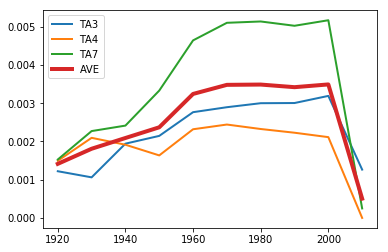

In [14]:
for i in range(1,len(gaus_plots)):
    if i in [1,4,5,7,8]:
        continue
    TA = 'TA'+str(i+1)
    gplot = gaus_plots[i]
    plt.plot( 'Year', str(TA), data=gplot, marker='', linewidth=2)
    
plt.plot( 'Year', 'AVE', data=aveplot, marker='', linewidth=4)
plt.legend()
plt.show()


#### Conclusion
In the above graphs, we have eliminated data that was either an outlier or that did not follow an interesting trend that we noticed developing in the dataset.  By plotting the three normalized features together in the above graph, we then applied an average across all three features to establish a trend baseline for describing the observed trend.  As an observation of our final data, the instruments/styles that these timbres represent fell out of popularity entering the 2000's and beyond.